In [39]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.0
1.5.3
1.24.2


# Step 1. 데이터 불러오기
   

In [44]:
data_dir = os.getenv("HOME") + '/aiffel/DATA'
tokenizer_name = 'cmsp'

In [45]:
# # train data load
data_dir = os.getenv('HOME')+'/aiffel/DATA/pickle' # 파일 경로 지정
data_train_path = data_dir+f"/data_train_{tokenizer_name}_16000_0324.pkl"
data_test_path = data_dir+f"/data_test_{tokenizer_name}_16000_0324.pkl"
full_data = pd.read_pickle(data_train_path, 'gzip')
full_data_test = pd.read_pickle(data_test_path, 'gzip')

In [46]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948219 entries, 0 to 949887
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   reg       948219 non-null  object
 1   topic     948219 non-null  object
 2   stdn      948219 non-null  object
 3   dial      948219 non-null  object
 4   eng       948219 non-null  object
 5   toks_en   948219 non-null  object
 6   toks_dec  948219 non-null  object
dtypes: object(7)
memory usage: 57.9+ MB


In [47]:
full_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 39379 to 297204
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       125 non-null    object
 1   topic     125 non-null    object
 2   stdn      125 non-null    object
 3   dial      125 non-null    object
 4   eng       125 non-null    object
 5   toks_en   125 non-null    object
 6   toks_dec  125 non-null    object
dtypes: object(7)
memory usage: 7.8+ KB


In [48]:
regs = full_data.reg.unique()

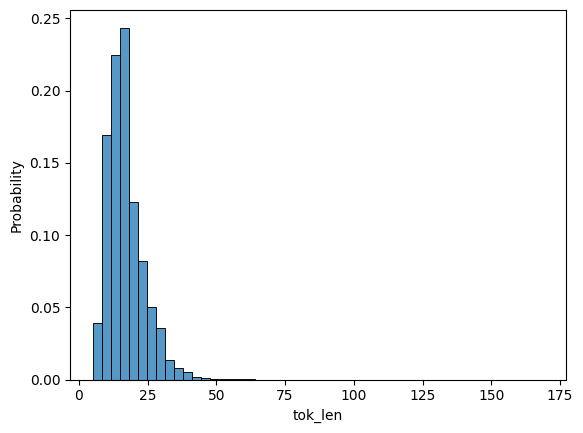

In [49]:
import seaborn as sns
full_data['tok_len'] = full_data['toks_en'].apply(lambda x : len(x))
sns.histplot(x='tok_len',data = full_data, bins= 50,stat='probability' )
plt.show()

In [50]:
full_data.groupby(full_data['reg'])['tok_len'].mean()

reg
cc    19.258820
gs    18.009518
jd    18.796067
jj    15.125946
kw    15.556690
Name: tok_len, dtype: float64

In [51]:
full_data['tok_cat'] = pd.qcut(full_data['tok_len'], [0,0.9,0.9999,1],labels =[1,2,3])

In [52]:
len(full_data.loc[full_data['tok_cat']==3,'tok_len'])

90

In [53]:
full_data.loc[full_data['tok_cat']==3,'tok_len'].agg([min,max])

min     68
max    169
Name: tok_len, dtype: int64

In [54]:
data_path = os.getenv('HOME') + '/aiffel/saturi/notebook/Preprocessing/'
sizes = 16009
SRC_VOCAB_SIZE = sizes
TGT_VOCAB_SIZE = sizes

enc_tokenizer = spm.SentencePieceProcessor()
enc_tokenizer.Load(data_path+'spm_enc_spm16000.model')

dec_tokenizer = spm.SentencePieceProcessor()
dec_tokenizer.Load(data_path+f'spm_dec_{tokenizer_name}16000.model')

dec_tokenizer.set_encode_extra_options("bos:eos")

True

# Step 2. 모델불러오기

In [55]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [56]:
#wandb 설정
warmups = 8500
project_name = f'model_exp_{tokenizer_name}_16000_0329_final_최종'
run  = wandb.init(project = project_name ,
                 entity = 'saturi',
                 config = {
                     'model_name':'Vanilla_Transformer',
                     'n_layers':6,
                     'd_model':512,
                     'n_heads':8,
                     'd_ff':2048,
                     'src_vocab_size':SRC_VOCAB_SIZE,
                     'tgt_vocab_size':TGT_VOCAB_SIZE,
                     'pos_len': 512,
                     'dropout':0.2,
                     'shared':True,
                     'warmups' : warmups,
                     'epochs':1,
                     'optimizer' :'ADAM',
                     'loss' : 'SparseCategoricalCrossentropy',
                     'metric' : 'bleu'
                 })
config = wandb.config

bleu,▁
train_loss,█▇▇▆▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▄▅▅▄▃▁▂▂▂▁█▆▇▇▅
bleu,15.45343
train_loss,2.84169
valid_loss,3.85542


In [57]:
import sys
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/MODEL/') # vanilla transformer 파일경로에서 불러오기 위해 설정
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/PRE/')
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/POST/')

In [58]:
from vanilla_transformer import Transformer, generate_masks

transformer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=config.src_vocab_size,
    tgt_vocab_size=config.tgt_vocab_size,
    pos_len=config.pos_len,
    dropout=config.dropout,
    shared=config.shared
)

##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언

In [59]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=config.warmups):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** np.array(-0.5)
        arg2 = step * np.array(self.warmup_steps ** -1.5)
        
        return np.array(self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [60]:
learningrate = LearningRateScheduler(512)

In [61]:
optimizer = tf.keras.optimizers.Adam(learningrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의


In [62]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의


In [63]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns, predictions

In [64]:
# Validating the model
@tf.function
def model_validate(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    v_loss = loss_function(gold, predictions[:, :-1])
    
    return v_loss, predictions

In [65]:
# 학습 매니저 설정
from evaluation import evaluate, compute_metric, translate
full_data = full_data.sample(frac=1).copy()

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        
        batch_size = 64
        buckets = iter(reversed(full_data['tok_cat'].unique().tolist()))

        for bucket in buckets :
            total_loss = 0     
            
            src_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_en'].values
            tgt_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_dec'].values
            src_valid_corpus = full_data_test['toks_en'].values
            tgt_valid_corpus = full_data_test['toks_dec'].values
            max_len = full_data.loc[full_data['tok_cat']==bucket,'tok_len'].max()

            if max_len > 380 :
                batch_size = 8

            if max_len > 512 : 
                max_len = 512


            enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post', maxlen=max_len)
            dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post', maxlen=max_len)
            enc_test = tf.keras.preprocessing.sequence.pad_sequences(src_valid_corpus, padding='post', maxlen=max_len)
            dec_test = tf.keras.preprocessing.sequence.pad_sequences(tgt_valid_corpus, padding='post', maxlen=max_len)
            
            idx_list = list(range(0, enc_train.shape[0], batch_size))
            random.shuffle(idx_list)

            t = tqdm(idx_list)
            
            for (batch, idx) in enumerate(t):
                batch_loss, enc_attns, dec_attns, dec_enc_attns, preds = train_step(enc_train[idx:idx+batch_size],
                                                                             dec_train[idx:idx+batch_size],
                                                                             transformer,
                                                                             optimizer)

                total_loss += batch_loss

                t.set_description_str('Bucket %2d' % (bucket))
                t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
                wandb.log({
                       "train_loss": (total_loss.numpy() / (batch + 1)),
                       })
            
            #validation
            total_loss_val = 0
            val_size=25
            tv = tqdm(range(0,enc_test.shape[0], val_size))
            
            for (batch_val,test_idx) in enumerate(tv) :
                val_loss, val_preds = model_validate(enc_test[test_idx : test_idx + val_size],
                                          dec_test[test_idx : test_idx + val_size],
                                          transformer)
                total_loss_val += val_loss
                tv.set_postfix_str('val_Loss %.4f' % (total_loss_val.numpy() / (batch_val + 1)))
                
                wandb.log({
                           "valid_loss" : (total_loss_val.numpy() / (batch_val + 1))
                           })

            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            
        # bleu score
        from datasets import load_metric

        bleu = load_metric("sacrebleu")
        test_translate = []
        bleu_valid_score = []
        
        test_text = full_data_test.eng.values
        test_tgt = full_data_test.dial.values
        
        for i in tqdm(range(len(test_text))) :
            trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
            test_translate.append(trans)
            label = dec_tokenizer.decode(test_tgt[i])
            result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
            bleu_valid_score.append(result)

        sum(bleu_valid_score)/len(test_text)
        wandb.log({"bleu": sum(bleu_valid_score)/len(test_text)})

        full_data_test['bleu'] = np.array(bleu_valid_score)
        full_data_test['pred'] = test_translate
            
directory = os.getenv('HOME') + '/aiffel/MODEL/'
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, directory +f'tf_{tokenizer_name}16000_ckpt_final_0329_최종',max_to_keep=6)

In [66]:
# import shutil
# dir_mo = os.getenv("HOME") + '/aiffel/MODEL'
# os.listdir(dir_mo)

In [67]:
# shutil.rmtree(dir_mo + '/##')

## 학습

In [68]:
for _ in range(7):
    run  = wandb.init(project = project_name,
                     entity = 'saturi',
                     config = {
                         'model_name':'Vanilla_Transformer',
                         'n_layers':6,
                         'd_model':512,
                         'n_heads':8,
                         'd_ff':2048,
                         'src_vocab_size':SRC_VOCAB_SIZE,
                         'tgt_vocab_size':TGT_VOCAB_SIZE,
                         'pos_len': 512,
                         'dropout':0.2,
                         'shared':True,
                         'warmups' : warmups,
                         'epochs':1,
                         'optimizer' :'ADAM',
                         'loss' : 'SparseCategoricalCrossentropy',
                         'metric' : 'bleu'
                     })
    train_and_checkpoint(transformer, manager, config.epochs)

Initializing from scratch.


100%|███████████████████████████| 5/5 [00:02<00:00,  2.47it/s, val_Loss 11.0509]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-1


100%|████████████████████████████| 5/5 [00:01<00:00,  2.78it/s, val_Loss 5.5661]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-2


100%|████████████████████████████| 5/5 [00:01<00:00,  2.94it/s, val_Loss 3.8252]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-3


100%|█████████████████████████████████████████| 125/125 [04:12<00:00,  2.02s/it]


bleu,▁
train_loss,█▆▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█████▂▃▃▃▃▁▁▁▁▁
bleu,12.79462
train_loss,4.36869
valid_loss,3.82516


Restored from /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-3


100%|████████████████████████████| 5/5 [00:00<00:00, 16.09it/s, val_Loss 3.8405]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-4


100%|████████████████████████████| 5/5 [00:00<00:00, 37.27it/s, val_Loss 3.5566]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-5


100%|████████████████████████████| 5/5 [00:00<00:00, 74.76it/s, val_Loss 3.4133]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-6


100%|█████████████████████████████████████████| 125/125 [03:57<00:00,  1.90s/it]


bleu,▁
train_loss,█▇▇▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▇██▇▆▂▅▅▃▃▁▃▄▃▂
bleu,14.31149
train_loss,3.43737
valid_loss,3.4133


Restored from /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-6


100%|████████████████████████████| 5/5 [00:00<00:00, 16.01it/s, val_Loss 3.3459]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-7


100%|████████████████████████████| 5/5 [00:00<00:00, 36.58it/s, val_Loss 3.2003]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-8


100%|████████████████████████████| 5/5 [00:00<00:00, 74.84it/s, val_Loss 3.2970]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-9


100%|█████████████████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]


bleu,▁
train_loss,█▇▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▃▇█▆▅▁▆▅▃▃▅▇█▆▄
bleu,16.76736
train_loss,3.09869
valid_loss,3.29702


Restored from /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-9


100%|████████████████████████████| 5/5 [00:00<00:00, 15.95it/s, val_Loss 3.2000]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-10


100%|████████████████████████████| 5/5 [00:00<00:00, 35.78it/s, val_Loss 3.0374]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-11


100%|████████████████████████████| 5/5 [00:00<00:00, 75.76it/s, val_Loss 3.2239]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-12


100%|█████████████████████████████████████████| 125/125 [04:16<00:00,  2.05s/it]


bleu,▁
train_loss,█▇▇▆▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▃▆▇▅▄▁▅▄▂▁▅██▆▄
bleu,15.33441
train_loss,2.88594
valid_loss,3.22392


Restored from /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-12


100%|████████████████████████████| 5/5 [00:00<00:00, 16.05it/s, val_Loss 3.1203]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-13


100%|████████████████████████████| 5/5 [00:00<00:00, 36.87it/s, val_Loss 3.0135]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-14


100%|████████████████████████████| 5/5 [00:00<00:00, 73.97it/s, val_Loss 3.2737]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-15


100%|█████████████████████████████████████████| 125/125 [04:20<00:00,  2.08s/it]


bleu,▁
train_loss,█▇▇▆▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▃▆▆▅▃▁▅▄▃▂▅▇█▆▅
bleu,14.79769
train_loss,2.71628
valid_loss,3.27373


Restored from /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-15


100%|████████████████████████████| 5/5 [00:00<00:00, 15.82it/s, val_Loss 3.1792]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-16


100%|████████████████████████████| 5/5 [00:00<00:00, 36.54it/s, val_Loss 3.0220]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-17


100%|████████████████████████████| 5/5 [00:00<00:00, 75.62it/s, val_Loss 3.2857]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-18


100%|█████████████████████████████████████████| 125/125 [04:19<00:00,  2.08s/it]


bleu,▁
train_loss,█▇▇▆▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▃▆▆▅▄▁▅▄▃▂▅▇█▇▅
bleu,15.15691
train_loss,2.56694
valid_loss,3.28568


Restored from /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-18


100%|████████████████████████████| 5/5 [00:00<00:00, 15.83it/s, val_Loss 3.1690]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-19


100%|████████████████████████████| 5/5 [00:00<00:00, 36.23it/s, val_Loss 3.0273]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-20


100%|████████████████████████████| 5/5 [00:00<00:00, 73.90it/s, val_Loss 3.3426]


Saved checkpoint for step 1: /home/seuyon0101/aiffel/MODEL/tf_cmsp16000_ckpt_final_0329_최종/ckpt-21


100%|█████████████████████████████████████████| 125/125 [04:30<00:00,  2.16s/it]


# Step 3. 평가

Text(0.5, 0, 'Train Step')

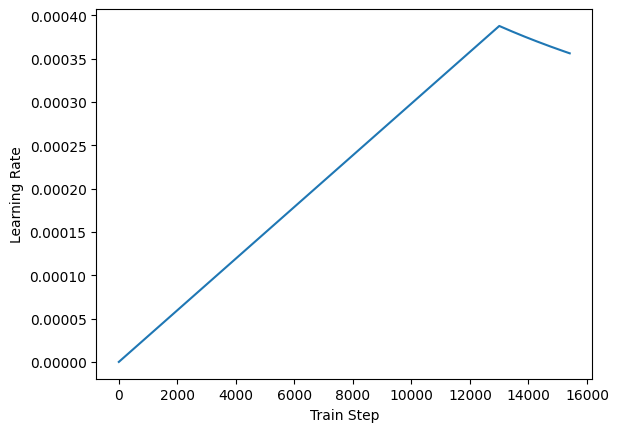

In [58]:
plt.plot(learningrate(tf.range(15412, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [59]:
from time import perf_counter

In [112]:
examples = ["<jj> what are you doing ?",'<cc> what are you doing ?','<gs> what are you doing ?','<jd> what are you doing ?','<kw> what are you doing ?']

In [110]:
examples = ["<jj> i like this song .",'<cc> i like this song . ','<gs> i like this song . ','<jd> i like this song . ','<kw> i like this song . ']

In [64]:
examples = ["<jj> Let's do homework together .","<cc> Let's do homework together .","<gs> Let's do homework together .","<jd> Let's do homework together .","<kw> Let's do homework together ."]

In [108]:
examples = ["<jj> Are you going to sleep ?","<cc> Are you going to sleep ?","<gs> Are you going to sleep ?","<jd> Are you going to sleep ?","<kw> Are you going to sleep ?"]

In [114]:
examples = ["<jj> I want to go out to eat .","<cc> I want to go out to eat .","<gs> I want to go out to eat .","<jd> I want to go out to eat .","<kw> I want to go out to eat ."]

In [115]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> I want to go out to eat .
Predicted translation: 아이 먹고정 하는 게 이.
Input: <cc> I want to go out to eat .
Predicted translation: 아이 아이 아이 아이 아이 아이 아이 아이 아이 밥
Input: <gs> I want to go out to eat .
Predicted translation: 아이 아이 아이 아이 아이 아이 아이 아이 아이 아이
Input: <jd> I want to go out to eat .
Predicted translation: 아이 먹고 나가고잉 싶은 게 아이지.
Input: <kw> I want to go out to eat .
Predicted translation: 아이 밥 먹으러 나갈려고 하는 게 꿈이었
7.8454682329902425


In [ ]:
from datasets import load_metric

bleu = load_metric("sacrebleu")
test_translate = []
bleu_valid_score = []

test_text = full_data_test.eng.values
test_tgt = full_data_test.dial.values

for i in tqdm(range(len(test_text))) :
    trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
    test_translate.append(trans)
    label = dec_tokenizer.decode(test_tgt[i])
    result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='floor', smooth_value=0.25)['score']
    bleu_valid_score.append(result)

full_data_test['bleu'] = np.array(bleu_valid_score)
full_data_test['pred'] = test_translate

In [116]:
full_data_test.bleu.mean()

15.353147485390716

In [117]:
full_data_test.loc[:,['topic','eng','reg','dial','pred','bleu']].sort_values('bleu', ascending=False).tail(30)

,topic,eng,reg,dial,pred,bleu
75397,회사/학교,<jd> So I just wanted to apologize and get goo...,jd,긍께 그냥 죄송하고 좋은 성적 받자 이런 맴으로 했는디 짐 신프도 그러네이,긍게 그냥 성적도 좋고 성적도 좋고 인제 같은 거 하고 싶은 거지.,8.182478
87483,영화,"<jd> I'm just waiting for time to come, and I ...",jd,그 영화 시간이 오기빨을 기다리고이런게 쫌 시간이 아깝다고 생각에서 영화관을 잘 안...,영화 올 때까지 막 와블 기달렸던 시간이 영화 영화 영화로 가면 시간이 지나가는 거...,8.109667
679063,재테크,<gs> So how long does the US government print ...,gs,그서 미국 정부가 언제까징 돈 찍어주꼬 빚있으머 대신 사주꼬 그르께 안 돼.,우리 언제부터 돈 얼마씩 돈 모아 가주꼬 돈 버느 거 있대이 아가 데뷔가 있으믄은,7.562316
869009,건강,<gs> My back was weak and I had surgery and tr...,gs,허리가 약해가지꼬 막 쫌 수술도 하꼬 치료도 받꼬 막 이런 상태여 가주꼬,허리가 약했꼬 또 아이까도 수술하꼬,5.925260
719816,가족,<cc> If you break your back you dont know wher...,cc,허리라도 뿌러지면은 앞으론 언니가 나가가꼬 어디 가서 설거지라도 해여 될지 몰르니께...,그~ 허리이 그 어 ⁇ 게 ⁇ 지 몰르는 겨 어 ⁇ 거나 하이튼 간이 잘해유.,5.803921
921810,회사/학교,<cc> When I changed my mind I went over you we...,cc,그른거 내 생각을 바뀌니께 확 넘어갔지 너넨 그런 거 있었어 사춘기 넌 아까 뭐 지...,아이패드가 바꼈어 아이패드를 우리가 사춘기를 갔을 때 이제 사춘기가 오잖아.,5.180525
855826,만화,<cc> So the commander in the Navy dispatches b...,cc,그서 해군이 있는 대장이 출동을 혀 근데 대장의 그런 전투력은 그냥 루피이 한 천 ...,긍까 대작군이 관한 처지가 처분했는디 전투적인 파워포는 그냥 파손,4.011274
898457,먹거리,"<gs> That~ 600 grams, what~ 500 grams?",gs,그~ 육백 그람에 오백 그람인가 그래 육마 원인데 지가 반은 먹거든.,그램 그램에 그램 그,3.367205
41305,연애/결혼,<jd> I've got it in the early 200 millionth ce...,jd,원래 이억 초반이면 얻었었거덩 근디 그렇고 많이 올라가갖고,아이패드라느 백칠십만 원짜리를 잡아갔댜,0.000000
406028,가족,<kw> That's why I have to give up on you.,kw,그래이 되이까 널 퍽데기할 수 밖에 없을 테이까,아이그 아즈매는 왜 퍽데기해야 하는가.,0.000000


In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
full_data_test.to_csv(data_dir + f'/test_results_{tokenizer_name}8000_final_needs_merge_327_stdn.csv')

In [ ]:
wandb.finish()